# CSU EDA v0.1
- 2022 to present
- split 3 ways:
    - awareness_markets: Orlando, Jacksonville, Greenville, SC and Birmingham
    - Mobile (DMA)
    - all other DMA
- USING LEAD ATTRIBUTED MEDIA SPEND

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [2]:
df_raw = pd.read_csv('../data/CSU_KPI_Media_2022-01-01_2025-01-02.csv')

In [3]:
dma_unique = list(df_raw['dmaname'].dropna().unique())
dma_unique.sort()

In [4]:
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

In [5]:
df = df_raw.copy()
df['leaddate'] = pd.to_datetime(df['leaddate']).dt.normalize()
df['appdate'] = pd.to_datetime(df['appdate']).dt.normalize()
df['enrolldate'] = pd.to_datetime(df['enrolldate']).dt.normalize()
df['split'] = None
df.loc[df['dmaname'].str.contains('|'.join(list_awareness), na=False), 'split'] = 'awareness'
df.loc[df['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'split'] = 'mobile'
df.loc[df['split'].isna(), 'split'] = 'other'
df = df.loc[df['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 
df['channel'] = None
df.loc[df['dw_channel'].str.contains('Referral'), 'channel'] = 'Referral'
df.loc[df['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df.loc[df['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)'

### Making cohort KPI data frame where all KPI are by the lead date
df_cohort = df.groupby(['leaddate', 'channel'])[['n_lead', 'n_app', 'n_enroll']].agg('sum')
df_cohort = df_cohort.unstack('channel').swaplevel(axis=1).sort_index(axis=1)
df_cohort['Total', 'n_lead'] = df_cohort.loc[:, pd.IndexSlice[:, 'n_lead']].sum(axis=1)
df_cohort['Total', 'n_app'] = df_cohort.loc[:, pd.IndexSlice[:, 'n_app']].sum(axis=1)
df_cohort['Total', 'n_enroll'] = df_cohort.loc[:, pd.IndexSlice[:, 'n_enroll']].sum(axis=1)
df_cohort = df_cohort[[('ALL(No PPL,Referral)', 'n_lead'), ('ALL(No PPL,Referral)', 'n_app'), ('ALL(No PPL,Referral)', 'n_enroll'),
            ('PPL', 'n_lead'), ('PPL','n_app'), ('PPL', 'n_enroll'),
            ('Referral', 'n_lead'), ('Referral', 'n_app'), ('Referral', 'n_enroll'), 
            ('Total', 'n_lead'), ('Total', 'n_app'), ('Total', 'n_enroll')]]
df_cohort.columns.names = ['channel', 'KPI']
df_cohort_monthly = df_cohort.resample('MS').sum()

### Making in-period KPI data frame where lead, app, enroll are all based on their own corresponding date
df_lead = df.groupby(['leaddate', 'channel'])['n_lead'].agg('sum').reset_index()
df_app = df.groupby(['appdate', 'channel'])['n_app'].agg('sum').reset_index()
df_enroll = df.groupby(['enrolldate', 'channel'])['n_enroll'].agg('sum').reset_index()
df_inperiod = df_lead.merge(df_app, left_on=['leaddate', 'channel'], right_on=['appdate', 'channel'], how='left')
df_inperiod = df_inperiod.merge(df_enroll, left_on=['leaddate', 'channel'], right_on=['enrolldate', 'channel'], how='left')
df_inperiod = df_inperiod.drop(['appdate', 'enrolldate'], axis=1).fillna(0).set_index('leaddate')
df_inperiod = df_inperiod.pivot(columns='channel').swaplevel(axis=1).sort_index(axis=1, level=0)
df_inperiod['Total', 'n_lead'] = df_inperiod.loc[:, pd.IndexSlice[:, 'n_lead']].sum(axis=1)
df_inperiod['Total', 'n_app'] = df_inperiod.loc[:, pd.IndexSlice[:, 'n_app']].sum(axis=1)
df_inperiod['Total', 'n_enroll'] = df_inperiod.loc[:, pd.IndexSlice[:, 'n_enroll']].sum(axis=1)
df_inperiod = df_inperiod[[('ALL(No PPL,Referral)', 'n_lead'), ('ALL(No PPL,Referral)', 'n_app'), ('ALL(No PPL,Referral)', 'n_enroll'),
            ('PPL', 'n_lead'), ('PPL','n_app'), ('PPL', 'n_enroll'),
            ('Referral', 'n_lead'), ('Referral', 'n_app'), ('Referral', 'n_enroll'), 
            ('Total', 'n_lead'), ('Total', 'n_app'), ('Total', 'n_enroll')]]
df_inperiod.columns.names = ['channel', 'KPI']
df_inperiod_monthly = df_inperiod.resample('MS').sum()

C:\Users\twolf\AppData\Local\Temp\ipykernel_26612\3619903845.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df['dmaname'].str.contains('|'.join(list_awareness), na=False), 'split'] = 'awareness'


In [6]:
df_inperiod

channel    ALL(No PPL,Referral)                   PPL                Referral  \
KPI                      n_lead n_app n_enroll n_lead n_app n_enroll   n_lead   
leaddate                                                                        
2022-01-01                90.00  0.00     0.00  16.00  0.00     0.00      NaN   
2022-01-02               117.00  6.00     0.00  50.00  3.00     0.00      NaN   
2022-01-03               163.00 19.00     0.00  72.00  9.00     0.00      NaN   
2022-01-04               143.00 28.00     1.00  97.00 11.00     0.00      NaN   
2022-01-05               159.00 21.00     1.00  49.00  2.00     0.00      NaN   
...                         ...   ...      ...    ...   ...      ...      ...   
2024-12-29               205.00  7.00     0.00   5.00  2.00     0.00     6.00   
2024-12-30               279.00 55.00     0.00  11.00  2.00     0.00    12.00   
2024-12-31               228.00 24.00     0.00  20.00  1.00     0.00     9.00   
2025-01-01               242.00 11.00   243.00  37.00  0.00    17.00    10.00   
2025-01-02               147.00  0.00     0.00  46.00  0.00     0.00     9.00   

channel                    Total                 
KPI        n_app n_enroll n_lead n_app n_enroll  
leaddate                                         
2022-01-01   NaN      NaN 106.00  0.00     0.00  
2022-01-02   NaN      NaN 167.00  9.00     0.00  
2022-01-03   NaN      NaN 235.00 28.00     0.00  
2022-01-04   NaN      NaN 240.00 39.00     1.00  
2022-01-05   NaN      NaN 208.00 23.00     1.00  
...          ...      ...    ...   ...      ...  
2024-12-29  0.00     0.00 216.00  9.00     0.00  
2024-12-30  4.00     0.00 302.00 61.00     0.00  
2024-12-31  2.00     0.00 257.00 27.00     0.00  
2025-01-01  0.00    38.00 289.00 11.00   298.00  
2025-01-02  0.00     0.00 202.00  0.00     0.00  

[1098 rows x 12 columns]

### call out: There are discrepancies with how to categorize media
- so i have split it how i see fit:
    - search: brand, nonBrand
    - video: youtube
    - social: meta, tiktok, linkedIn
    - display: display, archerOrganic, Discovery
    - awareness: ctv/ott, digital radio, OOH

In [7]:
df_media = df.copy()
df_media = df_media.groupby(['leaddate', 'dw_vendor','dw_channel', 'split'])['dw_grosscost'].agg('sum').reset_index()
df_media['channel'] = None
df_media['vendor'] = None
### setting up the channel column
df_media.loc[df_media['dw_channel'] == 'Search', 'channel'] = 'Search'
df_media.loc[df_media['dw_channel'] == 'Social', 'channel'] = 'Social'
df_media.loc[df_media['dw_vendor'].str.contains('|'.join(['Discovery', 'Display', 'ArcherOrg'])), 'channel'] = 'Display'
df_media.loc[df_media['dw_channel'] == 'Video', 'channel'] = 'Video'
df_media.loc[df_media['dw_vendor'].str.contains('|'.join(['YouTubeTrad', 'TTD Billboard', 'TTD Radio', 'TTD Video', 'CSUTRAD', 'SaveWithCSU',
                                                          'FacebookTRAD', 'TV', 'Billboard', 'Airport'])), 'channel'] = 'Awareness'
df_media.loc[df_media.channel.isna(), 'channel'] = 'Other'
### setting up the vendor column
df_media.loc[(df_media['channel'] == 'Search') & (df_media['dw_vendor'].str.contains('Brand')), 'vendor'] = 'Brand'
df_media.loc[(df_media['channel'] == 'Search') & (df_media['dw_vendor'].str.contains('NonBrand')), 'vendor'] = 'NonBrand'
df_media.loc[(df_media['channel'] == 'Social') & (df_media['dw_vendor'].str.contains('TikTok')), 'vendor'] = 'TikTok'
df_media.loc[(df_media['channel'] == 'Social') & (df_media['dw_vendor'].str.contains('Facebook')), 'vendor'] = 'Meta'
df_media.loc[(df_media['channel'] == 'Social') & (df_media['dw_vendor'].str.contains('Linkedin')), 'vendor'] = 'LinkedIn'
df_media.loc[df_media['channel'] == 'Video', 'vendor'] = 'YouTube'
df_media.loc[(df_media['channel'] == 'Display') & (df_media['dw_vendor'].str.contains('Discovery')), 'vendor'] = 'Discovery'
df_media.loc[(df_media['channel'] == 'Display') & (df_media['dw_vendor'].str.contains('Display')), 'vendor'] = 'Display'
df_media.loc[(df_media['channel'] == 'Display') & (df_media['dw_vendor'].str.contains('ArcherOrg')), 'vendor'] = 'ArcherOrg'
df_media.loc[(df_media['channel'] == 'Awareness') & (df_media['dw_vendor'].str.contains('TTD Video')), 'vendor'] = 'CTV/OTT'
df_media.loc[(df_media['channel'] == 'Awareness') & (df_media['dw_vendor'].str.contains('TTD Radio')), 'vendor'] = 'Digital Radio'
df_media.loc[(df_media['channel'] == 'Awareness') & (df_media['dw_vendor'].str.contains('|'.join(['Billboard', 'Airport', 'TTD Billboard',
                                                                                                  'CSUTRAD', 'SaveWithCSU']))), 'vendor'] = 'OOH'
df_media = df_media.groupby(['leaddate', 'channel', 'vendor'])['dw_grosscost'].agg('sum').reset_index()
df_media = df_media.pivot(index='leaddate', columns=['channel', 'vendor'], values='dw_grosscost').sort_index(axis=1, level=0)
df_media_monthly = df_media.resample('MS').sum()

In [8]:
df_media

channel    Awareness                      Display                     Search  \
vendor       CTV/OTT Digital Radio  OOH ArcherOrg Discovery Display    Brand   
leaddate                                                                       
2022-01-01       NaN           NaN  NaN       NaN    188.00   90.23 1,921.23   
2022-01-02       NaN           NaN  NaN       NaN    687.92  180.47 2,419.73   
2022-01-03       NaN           NaN  NaN       NaN    280.94  202.46 4,785.24   
2022-01-04       NaN           NaN  NaN       NaN    538.76   90.23 4,284.97   
2022-01-05       NaN           NaN  NaN       NaN    814.39  292.69 4,652.96   
...              ...           ...  ...       ...       ...     ...      ...   
2024-12-29       NaN           NaN  NaN    389.10  1,364.98     NaN 2,351.35   
2024-12-30       NaN           NaN 0.00    684.71  3,488.37     NaN 3,925.61   
2024-12-31       NaN           NaN  NaN       NaN    692.55     NaN 3,463.38   
2025-01-01       NaN           NaN  NaN       NaN  1,972.70     NaN 2,902.63   
2025-01-02       NaN           NaN  NaN       NaN      0.00     NaN     0.00   

channel                Social                     Video  
vendor      NonBrand LinkedIn     Meta   TikTok YouTube  
leaddate                                                 
2022-01-01  3,229.13      NaN 3,636.17      NaN  200.67  
2022-01-02  6,350.73      NaN 2,658.79      NaN     NaN  
2022-01-03  8,360.44      NaN 3,356.47      NaN     NaN  
2022-01-04  8,245.01      NaN 1,941.64      NaN     NaN  
2022-01-05  8,254.48      NaN 2,092.52      NaN     NaN  
...              ...      ...      ...      ...     ...  
2024-12-29 16,869.31   666.57 3,949.46   827.92  743.13  
2024-12-30 23,675.84 1,285.23 3,881.13   524.07  705.22  
2024-12-31 24,338.92   692.63 3,889.37 1,491.34     NaN  
2025-01-01 19,683.04 1,448.34 3,477.01 1,334.84  932.94  
2025-01-02      0.00     0.00     0.00     0.00    0.00  

[1098 rows x 12 columns]

In [9]:
### saving different df's to a single sheet
with pd.ExcelWriter('../data/csu_final_data_2025-01-02.xlsx') as writer:
    df.to_excel(writer, sheet_name='full_KPI_Media', index=False)
    df_cohort.to_excel(writer, sheet_name='KPI_cohort_daily', index=True, merge_cells=True)
    df_cohort_monthly.to_excel(writer, sheet_name='KPI_cohort_monthly', index=True, merge_cells=True)
    df_inperiod.to_excel(writer, sheet_name='KPI_inperiod_daily', index=True, merge_cells=True)   
    df_inperiod_monthly.to_excel(writer, sheet_name='KPI_inperiod_monthly', index=True, merge_cells=True)  
    df_media.to_excel(writer, sheet_name='media_daily', index=True, merge_cells=True)  
    df_media_monthly.to_excel(writer, sheet_name='media_monthly', index=True, merge_cells=True)  
    

# EDA

In [10]:
df[['n_lead', 'n_app', 'n_enroll']].sum()

n_lead      223804
n_app        45556
n_enroll     16349
dtype: int64

In [11]:
df.groupby('split')[['n_lead', 'n_app', 'n_enroll']].agg('sum')

,n_lead,n_app,n_enroll
split,,,
awareness,7453,1626,598
mobile,4610,1399,578
other,211741,42531,15173


In [12]:
df.groupby('channel')[['n_lead', 'n_app', 'n_enroll']].agg('sum')

,n_lead,n_app,n_enroll
channel,,,
"ALL(No PPL,Referral)",182140,37125,13792
PPL,34701,5338,889
Referral,6963,3093,1668


In [13]:
df.groupby('split')['dw_grosscost'].agg('sum')

split
awareness      901,228.78
mobile         349,500.15
other       18,788,543.41
Name: dw_grosscost, dtype: float64

In [14]:
df.groupby('channel')['dw_grosscost'].agg('sum')

channel
ALL(No PPL,Referral)   17,816,776.24
PPL                     2,222,496.10
Referral                        0.00
Name: dw_grosscost, dtype: float64

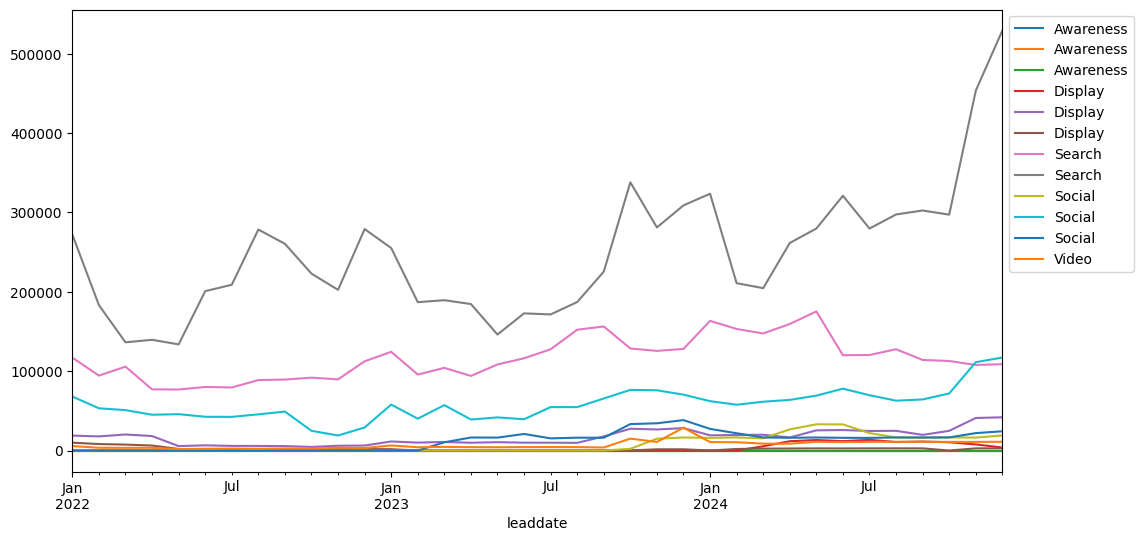

In [63]:
tmp = df_media_monthly.droplevel(1, axis=1)[:-1]
tmp.plot(figsize=(12,6))
plt.legend(bbox_to_anchor=(1, 1));